In [11]:
import os

import numpy as np
import pandas as pd
import json
import cv2
from sklearn.model_selection import train_test_split
import cv2

# tf imports
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from keras.layers import Dense
from keras import backend as K

import sys

# %pip install h5py
import h5py


['C:\\Program Files\\JetBrains\\PyCharm 2021.3.1\\plugins\\python\\helpers-pro\\jupyter_debug', 'C:\\Program Files\\JetBrains\\PyCharm 2021.3.1\\plugins\\python\\helpers\\pydev', 'D:\\GitHub\\plant-algo-s-and-whatnot\\Plant_variable_predictor', 'D:\\GitHub\\plant-algo-s-and-whatnot', 'C:\\Users\\joren\\anaconda3\\envs\\tf_try\\python37.zip', 'C:\\Users\\joren\\anaconda3\\envs\\tf_try\\DLLs', 'C:\\Users\\joren\\anaconda3\\envs\\tf_try\\lib', 'C:\\Users\\joren\\anaconda3\\envs\\tf_try', '', 'C:\\Users\\joren\\AppData\\Roaming\\Python\\Python37\\site-packages', 'C:\\Users\\joren\\anaconda3\\envs\\tf_try\\lib\\site-packages', 'C:\\Users\\joren\\anaconda3\\envs\\tf_try\\lib\\site-packages\\win32', 'C:\\Users\\joren\\anaconda3\\envs\\tf_try\\lib\\site-packages\\win32\\lib', 'C:\\Users\\joren\\anaconda3\\envs\\tf_try\\lib\\site-packages\\Pythonwin', 'C:\\Users\\joren\\anaconda3\\envs\\tf_try\\lib\\site-packages\\IPython\\extensions', 'C:\\Users\\joren\\.ipython']


In [12]:
def arrays_are_different(array1, array2):
    return not (array1 == array2)

def find_array_differences(array1, array2):
    set1 = set(array1)
    set2 = set(array2)
    return list(set1.difference(set2)), list(set2.difference(set1))

array1 = ['', 'C:\\Users\\joren\\anaconda3\\envs\\tf_try\\python37.zip', 'C:\\Users\\joren\\anaconda3\\envs\\tf_try\\DLLs', 'C:\\Users\\joren\\anaconda3\\envs\\tf_try\\lib', 'C:\\Users\\joren\\anaconda3\\envs\\tf_try', 'C:\\Users\\joren\\AppData\\Roaming\\Python\\Python37\\site-packages', 'C:\\Users\\joren\\anaconda3\\envs\\tf_try\\lib\\site-packages', 'C:\\Users\\joren\\anaconda3\\envs\\tf_try\\lib\\site-packages\\win32', 'C:\\Users\\joren\\anaconda3\\envs\\tf_try\\lib\\site-packages\\win32\\lib', 'C:\\Users\\joren\\anaconda3\\envs\\tf_try\\lib\\site-packages\\Pythonwin']

array2 = sys.path

differences = find_array_differences(array1, array2)
print(differences)

([], ['C:\\Program Files\\JetBrains\\PyCharm 2021.3.1\\plugins\\python\\helpers\\pydev', 'C:\\Program Files\\JetBrains\\PyCharm 2021.3.1\\plugins\\python\\helpers-pro\\jupyter_debug', 'D:\\GitHub\\plant-algo-s-and-whatnot\\Plant_variable_predictor', 'C:\\Users\\joren\\anaconda3\\envs\\tf_try\\lib\\site-packages\\IPython\\extensions', 'C:\\Users\\joren\\.ipython', 'D:\\GitHub\\plant-algo-s-and-whatnot'])


In [3]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.set_visible_devices(gpus[0], 'GPU')
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    print(e)

1 Physical GPUs, 1 Logical GPU


loading images with labels

In [4]:
f = open("..\data\measurements.json")
data_json = json.loads(f.read())["Measurements"]

vs = data_json.values()

df = pd.json_normalize(vs)

df.head()


,Variety,RGB_Image,Depth_Information,FreshWeightShoot,DryWeightShoot,Height,Diameter,LeafArea
0,Lugano,RGB_27.png,Depth_27.png,5.5,0.42,9.0,11.0,153.9
1,Lugano,RGB_79.png,Depth_79.png,30.3,1.92,8.8,20.2,582.3
2,Lugano,RGB_140.png,Depth_140.png,60.9,2.83,11.6,19.0,960.6
3,Lugano,RGB_203.png,Depth_203.png,112.0,5.76,11.0,22.0,1614.9
4,Lugano,RGB_292.png,Depth_292.png,372.6,14.17,17.0,32.0,3839.6


In [5]:
import albumentations as alb

def augment(train_set, train_labels, iterations):
    # Define a list of image augmentation transformations to apply
    aug_transforms = [
        alb.HorizontalFlip(),
        alb.VerticalFlip(),
        alb.RandomRotate90(),
        alb.Transpose(),
        alb.RandomBrightnessContrast()
    ]

    # Use the Compose function to apply the transformations
    aug = alb.Compose(aug_transforms)

    # Set the number of times to augment the images
    num_augmentations = iterations

    # Iterate through the number of augmentations
    for i in range(num_augmentations):
      # Iterate through your training set and apply the augmentations to each image
      augmented_train_set = []
      augmented_train_labels = []
      for image, label in zip(train_set, train_labels):
        augmented_image = aug(image=image)['image']
        augmented_train_set.append(augmented_image)
        augmented_train_labels.append(label)

      # Add the augmented images and labels to the training set
      train_set = np.concatenate((train_set, augmented_train_set))
      train_labels = np.concatenate((train_labels, augmented_train_labels))

    # Shuffle the training set and labels
    p = np.random.permutation(len(train_set))
    X = train_set[p]
    y = train_labels[p]
    return X, y


In [6]:
"""
    number: depth=0, RGB=1, depth/RGB=2, augment_data: amount of times for data to be augmented
"""
def prepare_data(number=0, y_key='Height', augment_data=0, normalized = True):

    all_images = []
    y = []

    if number == 2:
        path_RGB = '../data/RGBImagesResize/'
        key_RGB = 'RGB_Image'
        flag_RGB = cv2.IMREAD_COLOR

        path_depth = '../data/DepthImagesResize/'
        key_depth = 'Depth_Information'
        flag_depth = cv2.IMREAD_GRAYSCALE

        for image_path_RGB in os.listdir(path_RGB):
            if df.loc[df[key_RGB] == image_path_RGB][y_key].size > 0:
                img_ID = image_path_RGB.strip(".png").strip("RGB_")
                y.append(df.loc[df[key_RGB] == image_path_RGB][y_key].item())
                img_RGB = cv2.imread(path_RGB + image_path_RGB, flag_RGB)
                img_RGB = cv2.resize(img_RGB, (250, 250))
                image_path_depth = path_depth + "Depth_"+ img_ID + ".png"
                img_depth = cv2.imread(image_path_depth, flag_depth)
                img_depth = cv2.resize(img_depth, (250,250))
                if normalized:
                    img_RGB = img_RGB.astype(np.float32) / 255.0
                    img_depth = img_depth.astype(np.float32) / 255.0

                img_combined = np.dstack((img_RGB, img_depth))
                all_images.append(img_combined)
    else:
        if number == 1:
            path = '../data/RGBImagesResize/'
            key = 'RGB_Image'
            flag = cv2.IMREAD_COLOR
        else:
            path = '../data/DepthImagesResize/'
            key = 'Depth_Information'
            flag = cv2.IMREAD_GRAYSCALE

        for image_path in os.listdir(path):
            if df.loc[df[key] == image_path][y_key].size > 0:
                y.append(df.loc[df[key] == image_path][y_key].item())
                img = cv2.imread(path + image_path, flag)
                img = cv2.resize(img, (250, 250))
                if normalized:
                    img = img.astype(np.float32) / 255.0
                all_images.append(img)


    X_train, X_test, y_train, y_test = train_test_split(np.array(all_images), y, test_size=0.25, shuffle=True)

    if augment_data > 0:
        X_train, y_train = augment(X_train, y_train, augment_data)

    X_train = tf.convert_to_tensor(X_train)
    X_test = tf.convert_to_tensor(X_test)
    y_train = tf.convert_to_tensor(y_train)
    y_test = tf.convert_to_tensor(y_test)

    return X_train, y_train, X_test, y_test

ResNet Implementation for regression: depth images height

https://towardsdatascience.com/building-a-resnet-in-keras-e8f1322a49ba

!!LET OP NIET RUNNEN ZONDER GPU!!

In [7]:
from tensorflow import Tensor
from tensorflow.keras.layers import Input, Conv2D, ReLU, BatchNormalization, \
    Add, AveragePooling2D, Flatten, Dense
from tensorflow.keras.models import Model
from keras import regularizers



In [8]:
def relu_bn(inputs: Tensor) -> Tensor:
    relu = ReLU()(inputs)
    bn = BatchNormalization()(relu)
    return bn

In [9]:
def residual_block(x: Tensor, downsample: bool, filters: int, kernel_size: int = 3) -> Tensor:
    y = Conv2D(kernel_size=kernel_size,
               strides=(1 if not downsample else 2),
               filters=filters,
               padding="same")(x)
    y = relu_bn(y)
    y = Conv2D(kernel_size=kernel_size,
               strides=1,
               filters=filters,
               padding="same")(y)

    if downsample:
        x = Conv2D(kernel_size=1,
                   strides=2,
                   filters=filters,
                   padding="same")(x)
    out = Add()([x, y])
    out = relu_bn(out)
    return out

In [10]:
def create_res_net(input_shape):
    inputs = Input(shape=input_shape)
    num_filters = 64

    t = BatchNormalization()(inputs)
    t = Conv2D(kernel_size=3,
               strides=1,
               filters=num_filters,
               padding="same")(t)
    t = relu_bn(t)

    num_blocks_list = [2, 5, 5, 2]
    for i in range(len(num_blocks_list)):
        num_blocks = num_blocks_list[i]
        for j in range(num_blocks):
            t = residual_block(t, downsample=(j == 0 and i != 0), filters=num_filters)
        num_filters *= 2

    t = AveragePooling2D(4)(t)
    t = Flatten()(t)
    t = Dense(256, activation='relu', activity_regularizer=regularizers.l1(0.001))(t)
    outputs = Dense(1, activation='linear')(t)

    model = Model(inputs, outputs)

    model.compile(
            optimizer='adam',
            loss='mean_squared_error',
            metrics=['mean_absolute_percentage_error']
        )

    return model

In [11]:
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
import datetime
import os

def fit_model(model, epochs, batch_size, X_train, y_train, X_test, y_test):
    timestr = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    name = 'res_net'+timestr

    checkpoint_path = "checkpoints/"+name+"/cp-{epoch:04d}.ckpt"
    checkpoint_dir = os.path.dirname(checkpoint_path)
    os.system('mkdir {}'.format(checkpoint_dir))

    cp_callback = ModelCheckpoint(
        filepath=checkpoint_path,
        verbose=0,
        save_best_only=True,
        monitor='val_loss',
        mode='min'
    )
    tensorboard_callback = TensorBoard(
        log_dir=f'tensorboard_logs/{name}',
        histogram_freq=1
    )

    model.fit(
        x=X_train,
        y=y_train,
        epochs=epochs,
        verbose=1,
        validation_data=(X_test, y_test),
        batch_size=batch_size,
        callbacks=[cp_callback, tensorboard_callback]
    )

In [15]:

model = tf.keras.applications.ResNet50(weights='imagenet', include_top=True)

# Replace the original input layer with a new input layer that accepts the desired shape
new_input_layer = keras.layers.Input(shape=(250, 250, 3))
new_output = model(new_input_layer)
model = keras.Model(inputs=new_input_layer, outputs=new_output)

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_absolute_percentage_error'])
model.eval()

ImportError: DLL load failed: The specified procedure could not be found.

In [11]:
# model = create_res_net((250,250,3))
# X_train, y_train, X_test, y_test = prepare_data(1, 'LeafArea', 2, True)
# print(X_train.shape)
# fit_model(model, 100, 16, X_train, y_train, X_test, y_test)

(1160, 250, 250, 3)
Epoch 1/100
73/73 [==============================] - ETA: 0s - loss: 1274569.5000 - mean_absolute_percentage_error: 63.7259

INFO:tensorflow:Assets written to: checkpoints/res_net20221223-194604\cp-0001.ckpt\assets


INFO:tensorflow:Assets written to: checkpoints/res_net20221223-194604\cp-0001.ckpt\assets


73/73 [==============================] - 116s 1s/step - loss: 1274569.5000 - mean_absolute_percentage_error: 63.7259 - val_loss: 5693709.0000 - val_mean_absolute_percentage_error: 94.4210
Epoch 2/100
73/73 [==============================] - 79s 1s/step - loss: 665152.5625 - mean_absolute_percentage_error: 49.1896 - val_loss: 70573168.0000 - val_mean_absolute_percentage_error: 1802.0388
Epoch 3/100
73/73 [==============================] - 79s 1s/step - loss: 310347.1562 - mean_absolute_percentage_error: 37.4192 - val_loss: 27022628.0000 - val_mean_absolute_percentage_error: 493.8732
Epoch 4/100
73/73 [==============================] - 78s 1s/step - loss: 298508.3750 - mean_absolute_percentage_error: 36.9819 - val_loss: 13453324.0000 - val_mean_absolute_percentage_error: 217.2621
Epoch 5/100
73/73 [==============================] - ETA: 0s - loss: 261324.7500 - mean_absolute_percentage_error: 33.6828

INFO:tensorflow:Assets written to: checkpoints/res_net20221223-194604\cp-0005.ckpt\assets


INFO:tensorflow:Assets written to: checkpoints/res_net20221223-194604\cp-0005.ckpt\assets


73/73 [==============================] - 88s 1s/step - loss: 261324.7500 - mean_absolute_percentage_error: 33.6828 - val_loss: 5211179.5000 - val_mean_absolute_percentage_error: 128.7779
Epoch 6/100
73/73 [==============================] - ETA: 0s - loss: 248900.0312 - mean_absolute_percentage_error: 31.7598

INFO:tensorflow:Assets written to: checkpoints/res_net20221223-194604\cp-0006.ckpt\assets


INFO:tensorflow:Assets written to: checkpoints/res_net20221223-194604\cp-0006.ckpt\assets


73/73 [==============================] - 89s 1s/step - loss: 248900.0312 - mean_absolute_percentage_error: 31.7598 - val_loss: 1651796.5000 - val_mean_absolute_percentage_error: 104.2126
Epoch 7/100
73/73 [==============================] - 79s 1s/step - loss: 325516.1875 - mean_absolute_percentage_error: 44.4238 - val_loss: 1708866.0000 - val_mean_absolute_percentage_error: 63.7880
Epoch 8/100
73/73 [==============================] - ETA: 0s - loss: 256336.5000 - mean_absolute_percentage_error: 36.9044

INFO:tensorflow:Assets written to: checkpoints/res_net20221223-194604\cp-0008.ckpt\assets


INFO:tensorflow:Assets written to: checkpoints/res_net20221223-194604\cp-0008.ckpt\assets


73/73 [==============================] - 91s 1s/step - loss: 256336.5000 - mean_absolute_percentage_error: 36.9044 - val_loss: 1264231.8750 - val_mean_absolute_percentage_error: 47.5754
Epoch 9/100
73/73 [==============================] - ETA: 0s - loss: 252145.6562 - mean_absolute_percentage_error: 29.3712

INFO:tensorflow:Assets written to: checkpoints/res_net20221223-194604\cp-0009.ckpt\assets


INFO:tensorflow:Assets written to: checkpoints/res_net20221223-194604\cp-0009.ckpt\assets


73/73 [==============================] - 90s 1s/step - loss: 252145.6562 - mean_absolute_percentage_error: 29.3712 - val_loss: 217834.7188 - val_mean_absolute_percentage_error: 48.2429
Epoch 10/100
73/73 [==============================] - 80s 1s/step - loss: 231854.2344 - mean_absolute_percentage_error: 28.9384 - val_loss: 279399.1250 - val_mean_absolute_percentage_error: 44.0952
Epoch 11/100
73/73 [==============================] - ETA: 0s - loss: 219418.7656 - mean_absolute_percentage_error: 27.7529

INFO:tensorflow:Assets written to: checkpoints/res_net20221223-194604\cp-0011.ckpt\assets


INFO:tensorflow:Assets written to: checkpoints/res_net20221223-194604\cp-0011.ckpt\assets


73/73 [==============================] - 90s 1s/step - loss: 219418.7656 - mean_absolute_percentage_error: 27.7529 - val_loss: 204325.4844 - val_mean_absolute_percentage_error: 26.2531
Epoch 12/100
73/73 [==============================] - ETA: 0s - loss: 215851.0000 - mean_absolute_percentage_error: 28.0206

INFO:tensorflow:Assets written to: checkpoints/res_net20221223-194604\cp-0012.ckpt\assets


INFO:tensorflow:Assets written to: checkpoints/res_net20221223-194604\cp-0012.ckpt\assets


73/73 [==============================] - 90s 1s/step - loss: 215851.0000 - mean_absolute_percentage_error: 28.0206 - val_loss: 193825.7969 - val_mean_absolute_percentage_error: 26.2830
Epoch 13/100
73/73 [==============================] - 80s 1s/step - loss: 207914.9062 - mean_absolute_percentage_error: 29.1006 - val_loss: 239421.7656 - val_mean_absolute_percentage_error: 26.7733
Epoch 14/100
73/73 [==============================] - 80s 1s/step - loss: 202405.6719 - mean_absolute_percentage_error: 30.8504 - val_loss: 1422788.6250 - val_mean_absolute_percentage_error: 54.0338
Epoch 15/100
73/73 [==============================] - 80s 1s/step - loss: 209387.1250 - mean_absolute_percentage_error: 30.1643 - val_loss: 248204.5156 - val_mean_absolute_percentage_error: 48.9951
Epoch 16/100
73/73 [==============================] - 80s 1s/step - loss: 203933.7812 - mean_absolute_percentage_error: 29.3813 - val_loss: 1325061.7500 - val_mean_absolute_percentage_error: 89.6291
Epoch 17/100
73/73 [=

INFO:tensorflow:Assets written to: checkpoints/res_net20221223-194604\cp-0030.ckpt\assets


INFO:tensorflow:Assets written to: checkpoints/res_net20221223-194604\cp-0030.ckpt\assets


73/73 [==============================] - 91s 1s/step - loss: 140038.5312 - mean_absolute_percentage_error: 24.2285 - val_loss: 177655.8906 - val_mean_absolute_percentage_error: 34.2147
Epoch 31/100
73/73 [==============================] - ETA: 0s - loss: 149806.8906 - mean_absolute_percentage_error: 24.2082

INFO:tensorflow:Assets written to: checkpoints/res_net20221223-194604\cp-0031.ckpt\assets


INFO:tensorflow:Assets written to: checkpoints/res_net20221223-194604\cp-0031.ckpt\assets


73/73 [==============================] - 90s 1s/step - loss: 149806.8906 - mean_absolute_percentage_error: 24.2082 - val_loss: 173414.1406 - val_mean_absolute_percentage_error: 28.7305
Epoch 32/100
73/73 [==============================] - 80s 1s/step - loss: 139237.6562 - mean_absolute_percentage_error: 21.9793 - val_loss: 487406.3438 - val_mean_absolute_percentage_error: 34.2798
Epoch 33/100
73/73 [==============================] - 81s 1s/step - loss: 142194.1094 - mean_absolute_percentage_error: 23.1665 - val_loss: 211633.4688 - val_mean_absolute_percentage_error: 35.3855
Epoch 34/100
73/73 [==============================] - 81s 1s/step - loss: 126895.5703 - mean_absolute_percentage_error: 22.9745 - val_loss: 449426.2188 - val_mean_absolute_percentage_error: 28.7436
Epoch 35/100
73/73 [==============================] - ETA: 0s - loss: 128214.4375 - mean_absolute_percentage_error: 21.5862

INFO:tensorflow:Assets written to: checkpoints/res_net20221223-194604\cp-0035.ckpt\assets


INFO:tensorflow:Assets written to: checkpoints/res_net20221223-194604\cp-0035.ckpt\assets


73/73 [==============================] - 91s 1s/step - loss: 128214.4375 - mean_absolute_percentage_error: 21.5862 - val_loss: 148124.7969 - val_mean_absolute_percentage_error: 18.3551
Epoch 36/100
73/73 [==============================] - 81s 1s/step - loss: 122445.7266 - mean_absolute_percentage_error: 21.7998 - val_loss: 173914.4375 - val_mean_absolute_percentage_error: 40.8764
Epoch 37/100
73/73 [==============================] - 81s 1s/step - loss: 114256.3984 - mean_absolute_percentage_error: 21.7810 - val_loss: 421357.2812 - val_mean_absolute_percentage_error: 38.2021
Epoch 38/100
73/73 [==============================] - 82s 1s/step - loss: 115891.2969 - mean_absolute_percentage_error: 22.7823 - val_loss: 215395.5469 - val_mean_absolute_percentage_error: 24.4335
Epoch 39/100
73/73 [==============================] - 81s 1s/step - loss: 111620.6172 - mean_absolute_percentage_error: 22.1912 - val_loss: 201926.1719 - val_mean_absolute_percentage_error: 19.8066
Epoch 40/100
73/73 [===

KeyboardInterrupt: 

## Plots predicted vs actual

In [13]:
def plot_true_vs_predicted(model, X, y, title):
    predicted = model.predict(X)
    actual = y
    plt.plot(actual, 'bo')
    plt.plot(predicted, 'r^')

    # Draw lines between the data points
    for x1, y1, x2, y2 in zip(range(len(actual)), actual, range(len(predicted)), predicted):
        plt.plot([x1, x2], [y1, y2], 'k-')

    plt.title(title)
    plt.legend(['True data', 'Predicted data'])
    plt.show()


Diameter

4/4 [==============================] - 2s 508ms/step


C:\Users\joren\anaconda3\envs\tf_try\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


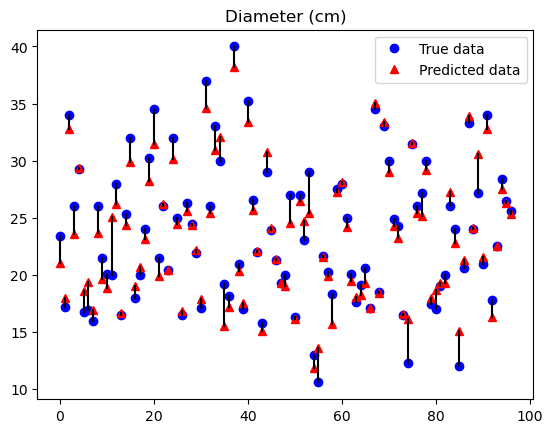

In [42]:
X_train, y_train, X_test, y_test = prepare_data(1,'Diameter',0, True)
model = tf.keras.models.load_model('./checkpoints/rgb_augm_reg_diameter/cp-0029.ckpt')
plot_true_vs_predicted(model, X_test, y_test, 'Diameter (cm)')

Height

4/4 [==============================] - 2s 567ms/step


C:\Users\joren\anaconda3\envs\tf_try\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


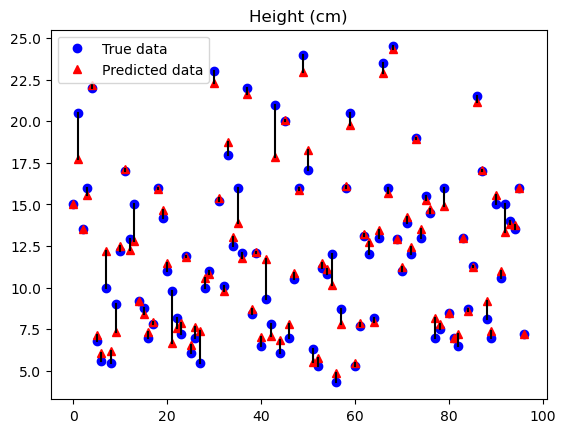

4/4 [==============================] - 2s 601ms/step


C:\Users\joren\anaconda3\envs\tf_try\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


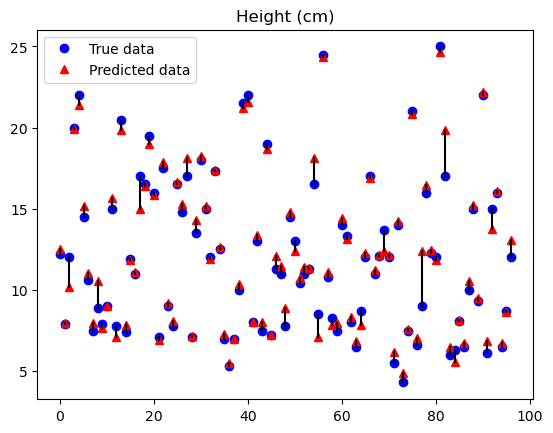

In [40]:
X_train, y_train, X_test, y_test = prepare_data(0,'Height',0, True)
model = tf.keras.models.load_model('./checkpoints/depth_reg_height/cp-0098.ckpt')
plot_true_vs_predicted(model, X_test, y_test, 'Height (cm)')

Fresh Weight

4/4 [==============================] - 2s 552ms/step


C:\Users\joren\anaconda3\envs\tf_try\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


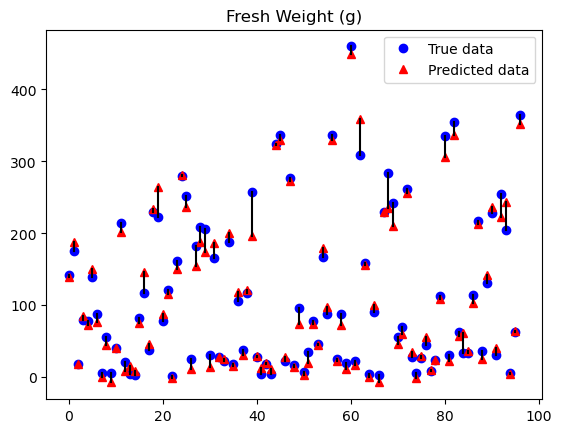

In [79]:
X_train, y_train, X_test, y_test = prepare_data(2,'FreshWeightShoot',0, False)
model = tf.keras.models.load_model('./checkpoints/rgb-d_freshweight/cp-0100.ckpt')
plot_true_vs_predicted(model, X_test, y_test, 'Fresh Weight (g)')

Dry Weight

4/4 [==============================] - 2s 565ms/step


C:\Users\joren\anaconda3\envs\tf_try\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


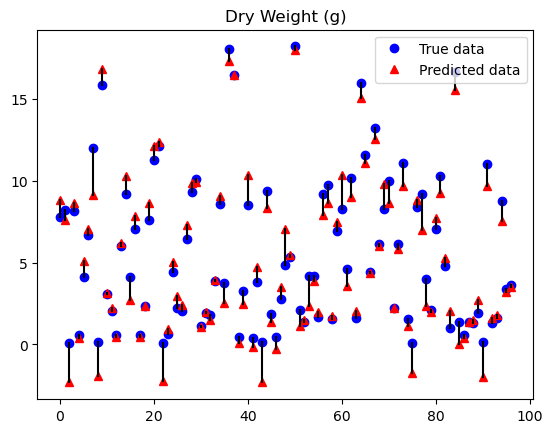

In [80]:
X_train, y_train, X_test, y_test = prepare_data(1,'DryWeightShoot',0, False)
model = tf.keras.models.load_model('./checkpoints/rgb_dryweight/cp-0077.ckpt')
plot_true_vs_predicted(model, X_test, y_test, 'Dry Weight (g)')

Leaf Area

4/4 [==============================] - 4s 360ms/step


C:\Users\joren\anaconda3\envs\tf_try\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


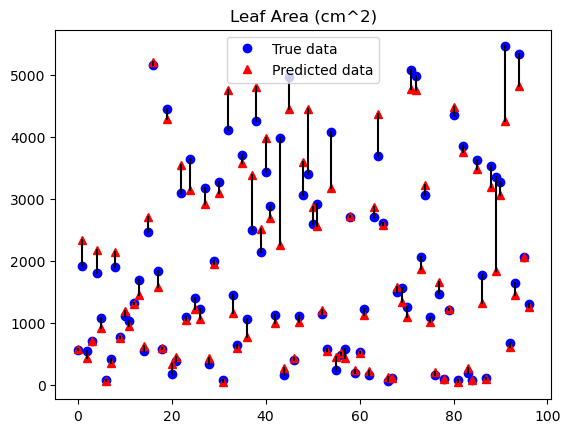

In [14]:
X_train, y_train, X_test, y_test = prepare_data(1,'LeafArea',0, True)
model = tf.keras.models.load_model('./checkpoints/rgb_augm_reg_leafarea/cp-0035.ckpt')
plot_true_vs_predicted(model, X_test, y_test, 'Leaf Area (cm^2)')